In [ ]:
# init repo notebook
!git clone https://github.com/rramosp/ppdl.git > /dev/null 2> /dev/null
!mv -n ppdl/content/init.py ppdl/content/local . 2> /dev/null
!pip install -r ppdl/content/requirements.txt > /dev/null

# Bijectors

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from rlxutils import subplots, copy_func
import tensorflow_probability as tfp
import tensorflow as tf
import ppdl 
import pandas as pd

tfd = tfp.distributions
tfb = tfp.bijectors

%matplotlib inline

## Bijectors are invertible transformations

When applied to TFP distributions bijectors produce fully valid distributions

TFP has a collection of [**Bijectors**](https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/) that allow you to transform distributions, keeping the capability for sampling and compute densities.

We will see them more in detail later in the course, but for now, let's understand what they do.

Observe how we scale and shift a distribution.

In [74]:
bscale = tfb.Scale(.5)
bshift = tfb.Shift(.3)

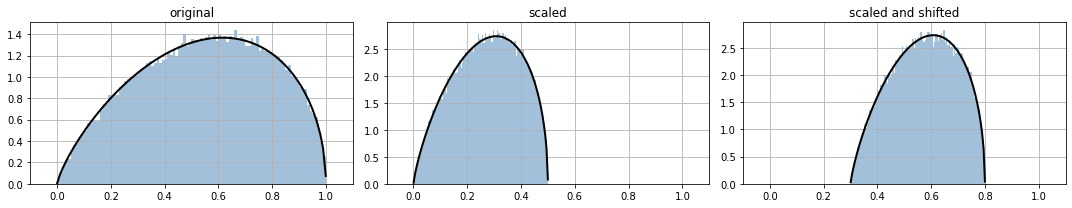

In [75]:
d_orig = tfd.Beta(1.8,1.5)
d_scaled = bscale(d_orig)
d_scaled_and_shifted = bshift(d_scaled)

for ax,i in subplots(range(3), usizex=5):
    if i==0: ppdl.plot_pdf(d_orig); plt.title("original")
    if i==1: ppdl.plot_pdf(d_scaled); plt.title("scaled")
    if i==2: ppdl.plot_pdf(d_scaled_and_shifted); plt.title("scaled and shifted")
    plt.xlim(-.1,1.1)
    plt.grid();
plt.tight_layout()

the resulting distribution are fully valid TFP distribution objects

In [76]:
d_scaled

<tfp.distributions.TransformedDistribution 'scaleBeta' batch_shape=[] event_shape=[] dtype=float32>

In [77]:
s = d_scaled.sample(10)
s

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.11156841, 0.39035392, 0.07765947, 0.19926141, 0.3500817 ,
       0.19258274, 0.16098109, 0.31810397, 0.10686599, 0.09793448],
      dtype=float32)>

In [78]:
d_scaled.log_prob(s)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.5458902 , 0.91539323, 0.29789424, 0.8819361 , 0.9846997 ,
       0.86564505, 0.77117884, 1.0047415 , 0.5174571 , 0.4588679 ],
      dtype=float32)>

## Chaining and inveting bijectors

you can chain bijectors to crete a new bijector. Observe that they are specied in **inverse order** to which they are applied.

you can also create an **inverse bijector**.

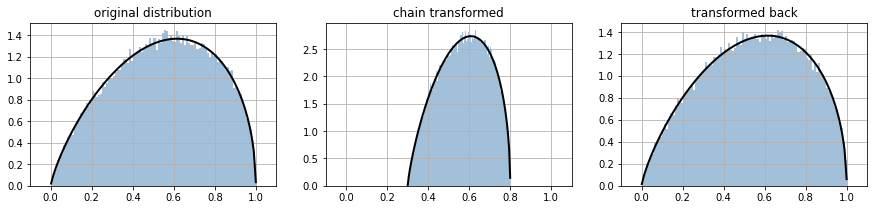

In [87]:
bc     = tfb.Chain([bshift,bscale])
bci    = tfb.Invert(bc)

dt     = bc(d_orig)
d_back = bci(dt)

for ax,i in subplots(3, usizex=5):
    if i==0: ppdl.plot_pdf(d_orig); plt.title("original distribution")
    if i==1: ppdl.plot_pdf(dt); plt.title("chain transformed")
    if i==2: ppdl.plot_pdf(d_back); plt.title("transformed back")
    plt.xlim(-.1,1.1)
    plt.grid();

## Bijector are general transformations on TF objects

In [70]:
x = tf.Variable(2.)
tx = bc(x)
tx

<tf.Tensor: shape=(), dtype=float32, numpy=1.3>

In [71]:
bc.inverse(tx)

<tf.Tensor: shape=(), dtype=float32, numpy=2.0>

## Modelling stuff

bijectors make it easier to model stuff with non standard distributions, for instance


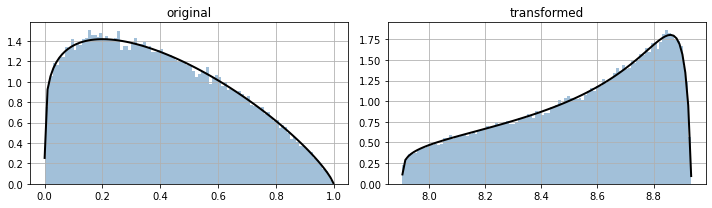

In [325]:
t = tfb.Chain([tfb.Scale(3), tfb.Shift(2), tfb.Tanh(), tfb.Scale(1.5), tfb.Shift(+.5)])
d1 = tfd.Beta(1.2,1.8)
d2 = t(d1)

for ax,i in subplots(2, usizex=5):
    if i==0: ppdl.plot_pdf(d1); plt.title("original")
    if i==1: ppdl.plot_pdf(d2); plt.title("transformed")
    plt.grid();
plt.tight_layout()

## `validate_args` 

Observe that sometimes a bijector might not be invertible for certain input values.

This is only checked in `validate_args` is set to `True`, otherwise, `nan` are generated and the code downstream will fail somewhere

In [219]:
t = tfb.Square()
d = tfd.Normal(loc=0, scale=1)
dt = t(d)
s = dt.sample(10)
s

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.05243969, 0.00711866, 0.3022964 , 0.08465093, 1.0127188 ,
       1.7130485 , 0.5749669 , 0.41861057, 0.9270925 , 0.80052745],
      dtype=float32)>

In [220]:
dt.prob(s)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.84852153, 2.3557818 ,        nan, 0.6571772 , 0.1194611 ,
       0.06471597, 0.19733593,        nan,        nan,        nan],
      dtype=float32)>

with `validate_args` set to `True` an exception is rised and can be dealt with

In [224]:
t = tfb.Square(validate_args=True)
d = tfd.Normal(loc=0, scale=1)
dt = t(d)
try:
    s = dt.sample(10)
except Exception as e:
    print (e)

All elements must be non-negative..  
Condition x >= 0 did not hold element-wise:
x (shape=(10,) dtype=float32) = 
['-0.9586899', '0.72535914', '1.2406634', '...']


but the code is slower even for a simple scenario. 
We test both cases with positive samples which we know are valid

In [247]:
t = tfb.Chain([tfb.Scale(2, validate_args=True), tfb.Square(validate_args=True)])
d = tfd.Normal(loc=100, scale=1)
dt = t(d)
%timeit s = dt.sample(1000)
%timeit dt.log_prob(s)

3.12 ms ± 34 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.94 ms ± 252 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [249]:
t = tfb.Square()
t = tfb.Chain([tfb.Scale(2), tfb.Square()])
d = tfd.Normal(loc=100, scale=1)
dt = t(d)
%timeit s = dt.sample(1000)
%timeit dt.log_prob(s)

2.92 ms ± 52.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.89 ms ± 413 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Bijector parameters are learnable

observe how we can learn altogether bijector and distribution parameters

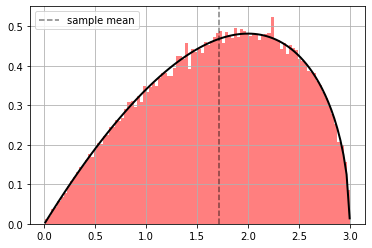

In [665]:

scale = tfb.Scale(3)
a,b = 2, 1.5
dbeta = tfd.Beta(a,b)
d_orig = scale(dbeta)  

x = d_orig.sample(100000)
ppdl.plot_pdf(d_orig, hist_args={'color': 'red', 'bins': 100, 'alpha': .5})
plt.axvline(np.mean(x), ls="--", color="black", alpha=.5, label="sample mean")
plt.grid(); plt.legend();

Although trivial, we will just learn the bijector parameter.

In [702]:
def optimize(init_sc=10., validate_args=False):
    
    sc = tf.Variable(init_sc, dtype=tf.float32)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)    

    hloss = []
    hgrads = []
    hparams = []
    for epoch in pbar(range(200)):

        with tf.GradientTape() as tape:
            c = tfb.Scale(sc)
            d = c(tfd.Beta(a,b, validate_args=validate_args))
            negloglik    = -tf.reduce_mean(d.log_prob(x))
            hloss.append(negloglik.numpy())

        gradients = tape.gradient(negloglik, [sc])
        if np.any([np.isnan(i) for i in gradients]):
            print("nan gradients")
            break
        optimizer.apply_gradients(zip(gradients,[sc]))
        hgrads.append(gradients)
        hparams.append(sc.numpy())

    hgrads = np.r_[hgrads]
    hloss = np.r_[hloss]
    hparams = np.r_[hparams]
    
    return hloss, hparams, hgrads, sc
    
def plot_optim(hloss, hparams, hgrads):
    for ax,i in subplots(3, usizex=5):
        if i==0: plt.plot(hloss); plt.title("loss")
        if i==1: plt.plot(hparams); plt.title("parameter value")
        if i==2: plt.plot(hgrads[:,0]); plt.title("paramter gradient")
        plt.xlabel("epoch")
        plt.grid();

In [700]:
hloss, hparams, hgrads, sc = optimize()
sc

100% (200 of 200) |######################| Elapsed Time: 0:00:03 Time:  0:00:03


<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.1905434>

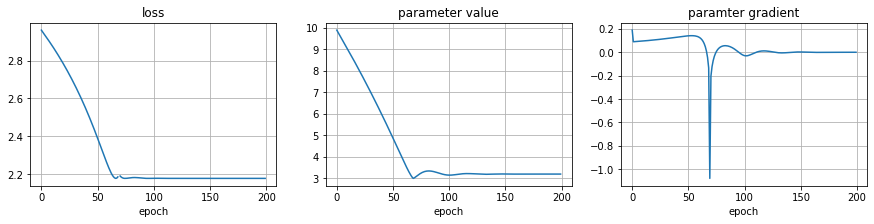

In [701]:
plot_optim(hloss, hparams, hgrads)

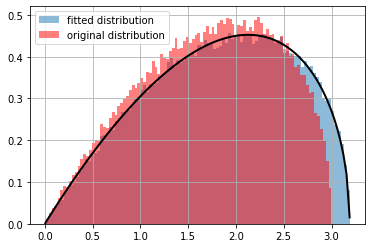

In [695]:
ppdl.plot_pdf(d, hist_args={'label': 'fitted distribution', 'bins': 100, 'alpha': .5})
plt.hist(x.numpy(), bins=100, density=True, alpha=.5, color="red", label="original distribution")
plt.grid(); plt.legend();

observe that we might hit invalid values during optimization. The Beta distribution returns `nan` if trying to compute densities for values outside its domain.

In [703]:
hloss, hparams, hgrads, sc = optimize(init_sc=-5)


 75% (150 of 200) |################      | Elapsed Time: 0:00:02 ETA:   0:00:00

nan gradients


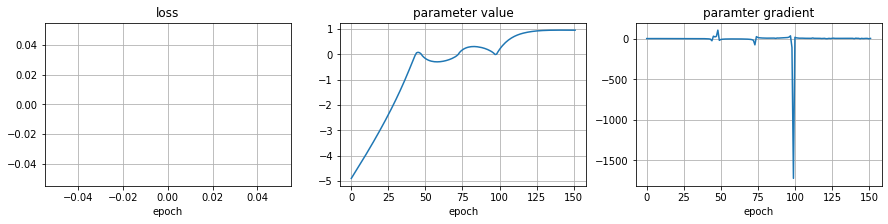

In [704]:
plot_optim(hloss, hparams, hgrads)

with `validate_args` set to `True` TFP checks stuff and will hint these situations

In [705]:
hloss, hparams, hgrads, sc = optimize(init_sc=-5, validate_args=True)


  0% (0 of 200) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

InvalidArgumentError: Sample must be non-negative..  
Condition x >= 0 did not hold element-wise:
x (shape=(100000,) dtype=float32) = 
['-0.44549665', '-0.05629177', '-0.39321715', '...']